# Demonstrate zarr-ification of CESM-LE

In [1]:
%matplotlib inline
import os
import shutil

import yaml

import xarray as xr

import intake
import intake_esm

import matplotlib.pyplot as plt

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


## Spinup cluster

In [2]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(4 * 9)  # Ask for 4 x 9 workers
cluster

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.200:45727 Dashboard: https://jupyterhub.ucar.edu/ch/user/abanihi/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Connect to intake-esm database

In [4]:
col = intake.open_esm_metadatastore(collection_name='CESM1-LE')
col.df.head()

,resource,resource_type,direct_access,experiment,case,component,stream,variable,date_range,member_id,file_fullpath,file_basename,file_dirname,ctrl_branch_year,year_offset,sequence_order,has_ocean_bgc,grid
0,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,18000101-18991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.180001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
1,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,08000101-08991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.080001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
2,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,04020101-04991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.040201...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
3,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,10000101-10991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.100001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN
4,CTRL:GLADE:posix:/glade/collections/cdg/data/c...,posix,True,CTRL,b.e11.B1850C5CN.f09_g16.005,atm,cam.h1,T200,11000101-11991231,0,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,b.e11.B1850C5CN.f09_g16.005.cam.h1.T200.110001...,/glade/collections/cdg/data/cesmLE/CESM-CAM5-B...,NaN,1448.0,0,True,NaN


## Specify process attributes

In [5]:
component_list = ['ocn',]

experiment_list = ['20C', ]

# these might not be good choices!
# zarr requirement: chunk size divides evenly into dim size
chunking_spec = yaml.safe_load('''
ocn:
  time: 12
  z_t: 20
  nlat: 128
  nlon: 80
''')

# vars to operate on
variable_request = yaml.safe_load('''
ocn:
  pop.h:
    - MOC
    - SHF
    - TEMP
''')
    

# file namer
dirout = '/glade/scratch/abanihi/calcs'
def zarr_file(exp, cmp, stream, var, write=False):
    path = f'{dirout}/CESM-LE.{exp}.{cmp}.{stream}.{var}.zarr'    
    if write and os.path.exists(path):
        shutil.rmtree(path)
    print(path)
    return path       

## Make `zarr` collection

In [6]:
# loop over experiments
for exp in experiment_list:
    
    # loop over model components
    for cmp in component_list:
        
        # set open_dataset keyword args
        xr_open = dict(chunks=chunking_spec[cmp], decode_times=False, decode_coords=False)
        
        # loop over streams
        for stm, varlist in variable_request[cmp].items():            
        
            # get the data
            for var in varlist:
                
                query = dict(experiment=exp, variable=var, stream=stm)            
                dd = col.search(**query).to_xarray(**xr_open)
                _, ds = dd.popitem()

                # apply subsetting in time
                # for proof of concept select only 3 years 
                # assuming monthly
                ds = ds.isel(time=slice(0, 36))

                # write a zarr file
                ds.to_zarr(zarr_file(exp, cmp, stm, var, write=True))


/glade/scratch/abanihi/calcs/CESM-LE.20C.ocn.pop.h.MOC.zarr



/glade/scratch/abanihi/calcs/CESM-LE.20C.ocn.pop.h.SHF.zarr



/glade/scratch/abanihi/calcs/CESM-LE.20C.ocn.pop.h.TEMP.zarr


## Read it back in to demonstrate merge

If we build a data catalog for the `zarr` collection, the reference to actually paths would go away. This is for illustration purposes only.

In [7]:
ds = xr.Dataset()
for var in ['SHF', 'TEMP']:
    dsi = xr.open_zarr(zarr_file('20C', 'ocn', 'pop.h', var))
    ds = xr.merge((ds, dsi))
ds.info()                       

/glade/scratch/abanihi/calcs/CESM-LE.20C.ocn.pop.h.SHF.zarr
/glade/scratch/abanihi/calcs/CESM-LE.20C.ocn.pop.h.TEMP.zarr
xarray.Dataset {
dimensions:
	d2 = 2 ;
	lat_aux_grid = 395 ;
	member_id = 40 ;
	moc_comp = 3 ;
	moc_z = 61 ;
	nlat = 384 ;
	nlon = 320 ;
	time = 36 ;
	transport_comp = 5 ;
	transport_reg = 2 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float64 ANGLE(nlat, nlon) ;
		ANGLE:long_name = angle grid makes with latitude line ;
		ANGLE:units = radians ;
	float64 ANGLET(nlat, nlon) ;
		ANGLET:long_name = angle grid makes with latitude line on T grid ;
		ANGLET:units = radians ;
	float64 DXT(nlat, nlon) ;
		DXT:long_name = x-spacing centered at T points ;
		DXT:units = centimeters ;
	float64 DXU(nlat, nlon) ;
		DXU:long_name = x-spacing centered at U points ;
		DXU:units = centimeters ;
	float64 DYT(nlat, nlon) ;
		DYT:long_name = y-spacing centered at T points ;
		DYT:units = centimeters ;
	float64 DYU(nlat, nlon) ;
		DYU:long_name =

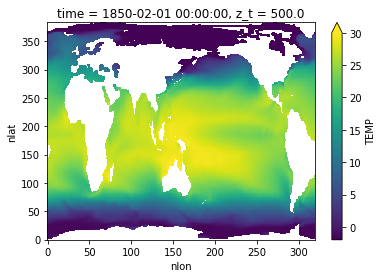

In [8]:
ds.TEMP.isel(z_t=0, time=0).mean('member_id').plot(vmin=-2, vmax=30)

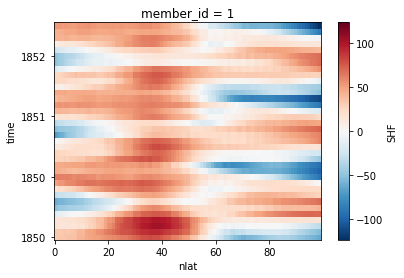

In [9]:
ds.SHF.isel(member_id=0, nlat=slice(150, 250), nlon=slice(150, 250)).mean('nlon').plot()